# Backtest Orbit Model

The way to gauge the performance of a time-series model is through re-training models with different historic periods and check their forecast within certain steps. This is similar to a time-based style cross-validation. More often, we called it `backtest` in time-series modeling.

The purpose of this notebook is to illustrate how to do 'backtest' on a single model using `BackTester`

`BackTester` will compose a `TimeSeriesSplitter` within it, but `TimeSeriesSplitter` is useful as a standalone, in case there are other tasks to perform that requires splitting but not backtesting. `TimeSeriesSplitter` implemented each 'slices' as genertor, i.e it can be used in a for loop. You can also retrieve the composed `TimeSeriesSplitter` object from `BackTester` to utilize the additional methods in `TimeSeriesSplitter`

Currently, there are two schemes supported for the back-testing engine: expanding window and rolling window.

* expanding window: for each back-testing model training, the train start date is fixed, while the train end date is extended forward.
* rolling window: for each back-testing model training, the training window length is fixed but the window is moving forward.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from orbit.models.lgt import LGTMAP, LGTAggregated
from orbit.models.dlt import DLTMAP
from orbit.diagnostics.backtest import BackTester, TimeSeriesSplitter
from orbit.utils.dataset import load_iclaims

import warnings
warnings.filterwarnings('ignore')

## Data - Initial Claim

First, let's load the example data set. Here we used weekly initial claims data from U.S. Employment and Training Administration. An initial claim is a claim filed by an unemployed individual after a separation from an employer. The claim requests a determination of basic eligibility for the Unemployment Insurance program. 

The dataset has 5 colums: 'week', 'claims', 'trend.unemploy', 'trend.filling' and 'trend.job'.

U.S. Employment and Training Administration, Initial Claims [ICNSA], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/ICNSA, January 3, 2021.

In [2]:
data = load_iclaims()
data[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']] = \
    np.log(data[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']])

In [3]:
data.head()

,week,claims,trend.unemploy,trend.filling,trend.job
0,2010-01-03,13.386595,0.168876,-0.328309,0.113033
1,2010-01-10,13.624218,0.168876,-0.204695,0.164326
2,2010-01-17,13.398741,0.185136,-0.302334,0.113033
3,2010-01-24,13.137549,0.152346,-0.204695,0.102451
4,2010-01-31,13.196760,0.083354,-0.252323,0.070016


array([<matplotlib.axes._subplots.AxesSubplot object at 0x131a6d6d8>,
      dtype=object)

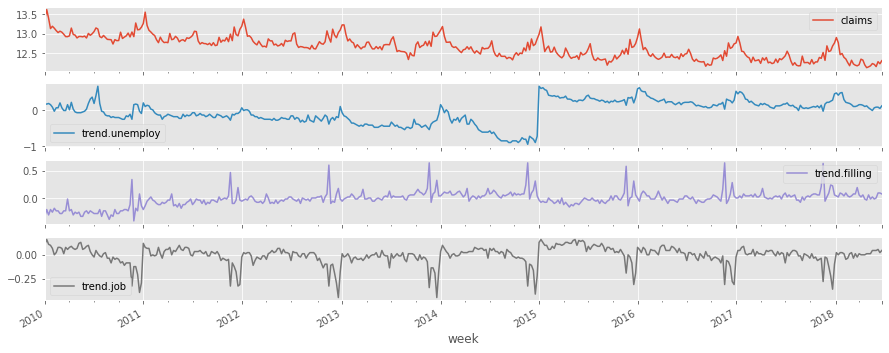

In [4]:
df_tmp = data.copy()
df_tmp.set_index('week', inplace = True) 
df_tmp.plot(subplots=True, figsize=(15,6))

## Create a TimeSeriesSplitter

There two main way to splitting a timeseries: expanding and rolling. Expanding window has a fixed starting point, and the window length grows as we move forward in timeseries. It is useful when we want to incoporate all historical information. On the other hand, rolling window has a fixed window length, and the starting point of the window moves forward as we move forward in timeseries. Now, we will illustrate how to use `TimeSeriesSplitter` to split the claims timeseries.

###  Expanding window

In [5]:
# configs
min_train_len = 380 # minimal length of window length
forecast_len = 20 # length forecast window
incremental_len = 20 # step length for moving forward

In [6]:
ex_splitter = TimeSeriesSplitter(data, min_train_len, incremental_len, forecast_len, 
                                 window_type='expanding', date_col='week')

In [7]:
print(ex_splitter)


------------ Fold: (1 / 3)------------
Train start index: 0 Train end index: 379
Test start index: 380 Test end index: 399
Train start date: 2010-01-03 00:00:00 Train end date: 2017-04-09 00:00:00
Test start date: 2017-04-16 00:00:00 Test end date: 2017-08-27 00:00:00

------------ Fold: (2 / 3)------------
Train start index: 0 Train end index: 399
Test start index: 400 Test end index: 419
Train start date: 2010-01-03 00:00:00 Train end date: 2017-08-27 00:00:00
Test start date: 2017-09-03 00:00:00 Test end date: 2018-01-14 00:00:00

------------ Fold: (3 / 3)------------
Train start index: 0 Train end index: 419
Test start index: 420 Test end index: 439
Train start date: 2010-01-03 00:00:00 Train end date: 2018-01-14 00:00:00
Test start date: 2018-01-21 00:00:00 Test end date: 2018-06-03 00:00:00



We can visualize the splits, green is training window and yellow it the forecasting windown. The starting point is always 0 for three splits but window length increases from 380 to 420. 

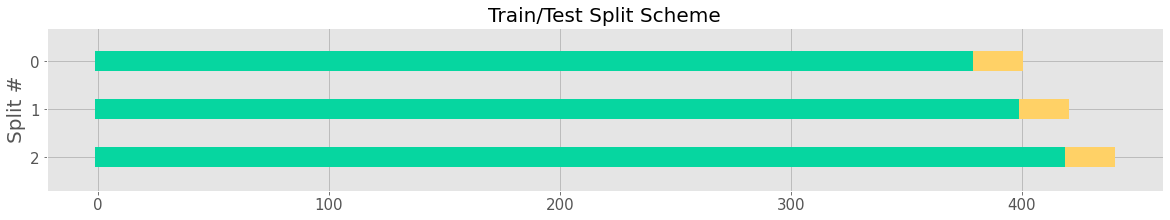

In [8]:
ex_splitter.plot()

### Rolling window

In [9]:
# configs
min_train_len = 380 # in case of rolling window, this specify the length of window length
forecast_len = 20 # length forecast window
incremental_len = 20 # step length for moving forward

In [10]:
roll_splitter = TimeSeriesSplitter(data, min_train_len, incremental_len, forecast_len, 
                                   window_type='rolling', date_col='week')

We can visualize the splits, green is training window and yellow it the forecasting windown. The window length is always 380, while the starting point moves forward 20 weeks each steps. 

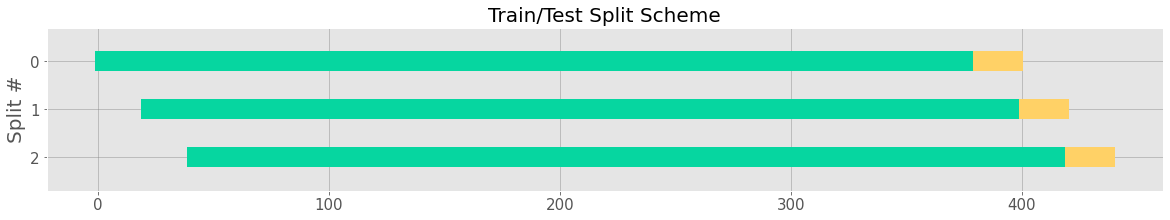

In [11]:
roll_splitter.plot()

### Specifying number of splits

User can also define number of splits using `n_splits` instead of specifying minimum training length.  That way, minimum training length will be automatically calculated.

In [12]:
ex_splitter2 = TimeSeriesSplitter(data, min_train_len, incremental_len, forecast_len, 
                                  n_splits=5, window_type='expanding', date_col='week')

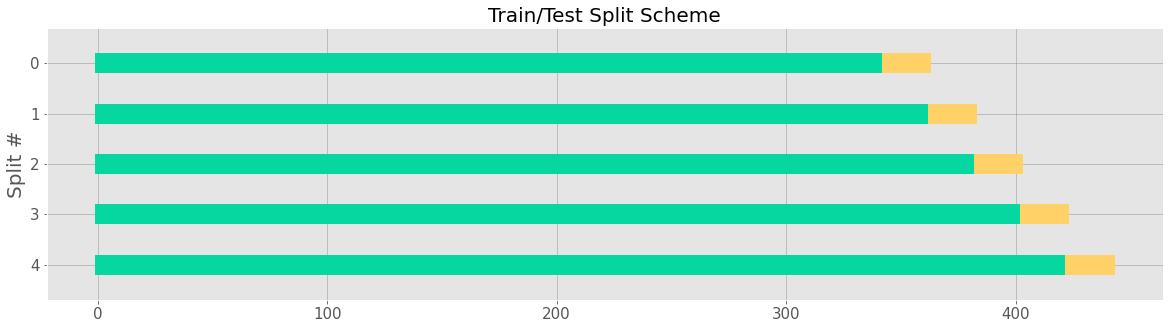

In [13]:
ex_splitter2.plot()

### TimeSeriesSplitter as generator

`TimeSeriesSplitter` is implemented as a genetor, therefore we can call `split()` to loop through it. It comes handy even for tasks other than backtest. 

In [14]:
 for train_df, test_df, scheme, key in roll_splitter.split():
        print('Initial Claim slice {} rolling mean:{}'.format(key, train_df['claims'].mean()))

Initial Claim slice 0 rolling mean:12.712341458856958
Initial Claim slice 1 rolling mean:12.67144746151623
Initial Claim slice 2 rolling mean:12.64657747604057


## Create a BackTester

Now, we are ready to do backtest, first let's initialize a `DLT` model and a `BackTester`. You pass in `TimeSeriesSplitter` parameters to `BackTester`. 

In [15]:
# instantiate a model
dlt = DLTMAP(
    date_col='week',
    response_col='claims',
    regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    seasonality=52,
)

In [16]:
# configs
min_train_len = 100 
forecast_len = 20 
incremental_len = 100 
window_type = 'expanding'

bt = BackTester(
    model=dlt,
    df=data,
    min_train_len,
    incremental_len,
    forecast_len,
    window_type
)

## Backtest fit and predict

The most expensive portion of backtesting is fitting the model iteratively. Thus, we separate the api calls for `fit_predict` and `score` to avoid redundant computation for multiple metrics or scoring methods

In [17]:
bt.fit_predict()

Once `fit_predict()` is called, the fitted models and predictions can be easily retrieved from `BackTester`. Here the data is grouped by the date, split_key, and whether or not that observation is part of the training or test data

In [18]:
predicted_df = bt.get_predicted_df()
predicted_df.head()

,date,split_key,training_data,actuals,prediction
0,2010-01-03,0,True,13.386595,13.386595
1,2010-01-10,0,True,13.624218,13.647009
2,2010-01-17,0,True,13.398741,13.371699
3,2010-01-24,0,True,13.137549,13.210528
4,2010-01-31,0,True,13.196760,13.187624


Users might find this useful for any custom computations that may need to be performed on the set of predicted data. Note that the columns are renamed to generic and consistent names.

Sometimes, it might be useful to match the data back to the original dataset for ad-hoc diagnostics. This can easily be done by merging back to the orignal dataset

In [19]:
predicted_df.merge(data, left_on='date', right_on='week')

,date,split_key,training_data,actuals,prediction,week,claims,trend.unemploy,trend.filling,trend.job
0,2010-01-03,0,True,13.386595,13.386595,2010-01-03,13.386595,0.168876,-0.328309,0.113033
1,2010-01-03,1,True,13.386595,13.386595,2010-01-03,13.386595,0.168876,-0.328309,0.113033
2,2010-01-03,2,True,13.386595,13.386595,2010-01-03,13.386595,0.168876,-0.328309,0.113033
3,2010-01-03,3,True,13.386595,13.386595,2010-01-03,13.386595,0.168876,-0.328309,0.113033
4,2010-01-10,0,True,13.624218,13.647009,2010-01-10,13.624218,0.168876,-0.204695,0.164326
...,...,...,...,...,...,...,...,...,...,...
1075,2017-12-17,3,False,12.568616,12.566179,2017-12-17,12.568616,0.247657,0.238797,-0.221336
1076,2017-12-24,3,False,12.691451,12.675558,2017-12-24,12.691451,0.277510,0.223759,-0.363306
1077,2017-12-31,3,False,12.769532,12.782945,2017-12-31,12.769532,0.452451,0.059456,-0.097038
1078,2018-01-07,3,False,12.908227,12.799636,2018-01-07,12.908227,0.476842,0.041438,0.025064


## Backtest Scoring

The main purpose of `BackTester` are the evaluation metrics. Some of the most widely used metrics are implemented and built into the `BackTester` API.

The default metric list is **smape, wmape, mape, mse, mae, rmsse**.

In [20]:
bt.score()

,metric_name,metric_values,is_training_metric
0,smape,0.006744,False
1,wmape,0.006740,False
2,mape,0.006726,False
3,mse,0.013021,False
4,mae,0.085628,False
5,rmsse,0.814492,False


It is possible to filter for only specific metrics of interest, or even implement your own callable and pass into the `score()` method. For example, see this function that uses last observed value as a predictor and computes the `mse`. Or `naive_error` which computes the error as the delta between predicted values and the training period mean. 

Note these are not really useful error metrics, just showing some examples of callables you can use ;)

In [21]:
def mse_naive(test_actual):
    actual = test_actual[1:]
    predicted = test_actual[:-1]
    return np.mean(np.square(actual - predicted))

def naive_error(train_actual, test_predicted):
    train_mean = np.mean(train_actual)
    return np.mean(np.abs(test_predicted - train_mean))

In [22]:
bt.score(metrics=[mse_naive, naive_error])

,metric_name,metric_values,is_training_metric
0,mse_naive,0.019628,False
1,naive_error,0.230315,False


It doesn't take additional time to refit and predict the model, since the results are stored when `fit_predict()` is called. Check docstrings for function criteria that is required for it to be supported with this api.

In some cases, we may want to evaluate our metrics on both train and test data. To do this you can call score again with the following indicator

In [23]:
bt.score(include_training_metrics=True)

,metric_name,metric_values,is_training_metric
0,smape,0.006744,False
1,wmape,0.006740,False
2,mape,0.006726,False
3,mse,0.013021,False
4,mae,0.085628,False
5,rmsse,0.814492,False
6,smape,0.002739,True
7,wmape,0.002742,True
8,mape,0.002738,True
9,mse,0.003118,True


## Backtest Get Models

In cases where `BackTester` doesn't cut it or for more custom use-cases, there's an interface to export the `TimeSeriesSplitter` and predicted data, as shown earlier. It's also possible to get each of the fitted models for deeper diving

In [24]:
fitted_models = bt.get_fitted_models()

In [25]:
model_1 = fitted_models[0]
model_1.get_regression_coefs()

,regressor,regressor_sign,coefficient
0,trend.unemploy,Regular,-0.045671
1,trend.filling,Regular,-0.108378
2,trend.job,Regular,0.031345


BackTester composes a TimeSeriesSplitter within it, but TimeSeriesSplitter can also be created on its own as a standalone object. See section below on TimeSeriesSplitter for more details on how to use the splitter.

All of the additional TimeSeriesSplitter args can also be passed into BackTester on instantiation

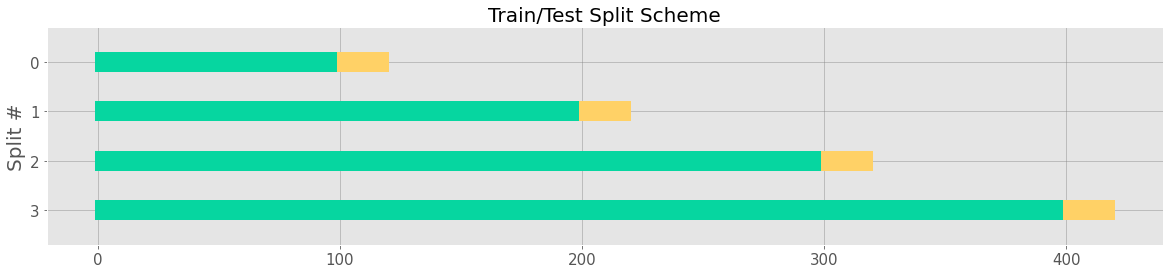

In [26]:
ts_splitter = bt.get_splitter()
ts_splitter.plot()

## Hyperparameter_Tunning
After seeing the results fromt the backtest, users may wish to fine tune the hyperparmeters. Orbit also provide a `grid_search_orbit` utilities for parameter searching. It uses `Backtester` under the hood so users can compare backtest metrics for different paramters combination.

In [27]:
from orbit.diagnostics.backtest import grid_search_orbit
# defining the search space for level smoothing paramter and seasonality smooth paramter
param_grid = {
    'level_sm_input': [0.3, 0.5, 0.8],  
    'seasonality_sm_input': [0.3, 0.5, 0.8],
}

In [28]:
# configs
min_train_len = 380 # in case of rolling window, this specify the length of window length
forecast_len = 20 # length forecast window
incremental_len = 20 # step length for moving forward
best_params, tuned_df = grid_search_orbit(param_grid, 
                                        model=dlt, 
                                        df=data,
                                        min_train_len, incremental_len, forecast_len, 
                                        metrics=None, criteria=None, verbose=True)

  0%|          | 0/9 [00:00<?, ?it/s]

tuning hyper-params {'level_sm_input': 0.3, 'seasonality_sm_input': 0.3}


 11%|█         | 1/9 [00:00<00:03,  2.51it/s]

tuning metric:0.0069549
tuning hyper-params {'level_sm_input': 0.3, 'seasonality_sm_input': 0.5}


 22%|██▏       | 2/9 [00:00<00:02,  2.49it/s]

tuning metric:0.0064769
tuning hyper-params {'level_sm_input': 0.3, 'seasonality_sm_input': 0.8}


 33%|███▎      | 3/9 [00:01<00:02,  2.49it/s]

tuning metric:0.0062834
tuning hyper-params {'level_sm_input': 0.5, 'seasonality_sm_input': 0.3}


 44%|████▍     | 4/9 [00:01<00:02,  2.37it/s]

tuning metric:0.0074489
tuning hyper-params {'level_sm_input': 0.5, 'seasonality_sm_input': 0.5}


 56%|█████▌    | 5/9 [00:02<00:01,  2.39it/s]

tuning metric:0.0070464
tuning hyper-params {'level_sm_input': 0.5, 'seasonality_sm_input': 0.8}


 67%|██████▋   | 6/9 [00:02<00:01,  2.25it/s]

tuning metric:0.0066297
tuning hyper-params {'level_sm_input': 0.8, 'seasonality_sm_input': 0.3}


 78%|███████▊  | 7/9 [00:03<00:01,  1.95it/s]

tuning metric:0.0094182
tuning hyper-params {'level_sm_input': 0.8, 'seasonality_sm_input': 0.5}


 89%|████████▉ | 8/9 [00:03<00:00,  1.85it/s]

tuning metric:0.0088091
tuning hyper-params {'level_sm_input': 0.8, 'seasonality_sm_input': 0.8}


100%|██████████| 9/9 [00:04<00:00,  2.05it/s]

tuning metric:0.0078637


In [29]:
tuned_df.head() # backtest output for each parameter searched

,level_sm_input,seasonality_sm_input,metrics
0,0.3,0.3,0.006955
1,0.3,0.5,0.006477
2,0.3,0.8,0.006283
3,0.5,0.3,0.007449
4,0.5,0.5,0.007046


In [30]:
best_params # output best parameters

[{'level_sm_input': 0.3, 'seasonality_sm_input': 0.8}]